# Phase Kickback (фазовый откат?)

В деталях об этом явлении можно почитать в [qiskit texbook](https://qiskit.org/textbook/ch-algorithms/grover.html). Для нас оно будет нужно, чтобы сконветировать "классическую функцию" (оракул) $f$ в функцию определённого вида.

## Фаза

Для начала, напомним, что такое **фаза**. Существуют состояния-суперпозиции, которые при измерении дают нам одинаковые вероятности наблюдения, например

$|\psi_+\rangle=|+\rangle=\frac{1}{\sqrt{2}}(|0\rangle+|1\rangle)$

и

$|\psi_-\rangle=|-\rangle=\frac{1}{\sqrt{2}}(|0\rangle-|1\rangle)$

Если вы попытаетесь из измерить, то различить их не удастся. Тем не менее мы знаем, что если применить к каждому из них вентиль Адамара, то мы получим уже разные результаты! 

А вообще их бесконечно много. В общем виде все такие равноверятные состояния можно записать как

$|\psi\rangle=\frac{1}{\sqrt{2}}(|0\rangle+e^{i\phi}|1\rangle)$,

где $\phi$ -- и есть фаза. Приведённые выше примеры -- частные случаи для $\phi=0, \pi$. Но именно они нам и будут интересны.

NB! Непосредственно фазу наблюдать мы не можем, но она может влиять не результаты последующих вычислений.

## Собственные векторы (состояния) и значения (фазы)

Собственным (для матрицы) называется так вектор, который она не в состоянии "испортить". Самое страшное что матрица-оператор может сделать с вектором -- умножить его на **какую-нибудь константу** (эту константу и называют собственным значением). Сколько вы не применяйте $X$ к состоянию $|+\rangle$, оно останется неизменным.

У матрицы 2x2 не больше чем 2 собственных вектора. Для оператора $NOT$ ими являются векторы-состояния $|+\rangle$ и $|-\rangle$ с собственными значениями 1 и -1 соответственно.

$X|-\rangle = X\frac{1}{\sqrt{2}}(|0\rangle-|1\rangle)=\frac{1}{\sqrt{2}}(|1\rangle-|0\rangle)=-\frac{1}{\sqrt{2}}(|0\rangle-|1\rangle)=-|-\rangle$.

Этим интересными свойствами и пользуется phase kickback:

Если мы применим контролируемый оператор (в нашем случае $CNOT$) к собственному состоянию (например, $|-\rangle$), то собственное значение для этого состояния запрыгнет в **фазу управляющего кубита (или даже регистра)**. Такого мы не ожидали! Мы думали, что управляющий кубит (или регистр) неизменны, но это не так. Это математическая особенность нам будет очень на руку при реализации алгоритма Гровера.


Вот так например можно найти собственные вектора и значения для поизвольных операторов:

In [1]:
## TODO compute eigenstates on X
import numpy as np
X = np.array([[0., 1], [1, 0]])
evals, evecs = np.linalg.eig(X)
for i in range(X.shape[0]):
    print("Собственное значение:", evals[i], end='\t')
    print("Собственный вектор:", evecs[:, i])

Собственное значение: 1.0	Собственный вектор: [0.70710678 0.70710678]
Собственное значение: -1.0	Собственный вектор: [-0.70710678  0.70710678]


Как проверить этот эффект на $CNOT$? Очень просто. Если подготовить:
- управляющий кубит в $|+\rangle$,
- управляемый кубит в $|-\rangle$,

то после применения CNOT можно ожидать, что управляющий $\frac{1}{\sqrt{2}}(|0\rangle+|1\rangle)$ превратится в $\frac{1}{\sqrt{2}}(|0\rangle+(-1)|1\rangle)=|-\rangle$. А значит, применив $H$, мы должны будем получить $|1\rangle$!

     ┌───┐ ░            ░       ░ ┌───┐┌─┐
q_0: ┤ H ├─░────────────░───■───░─┤ H ├┤M├
     └───┘ ░ ┌───┐┌───┐ ░ ┌─┴─┐ ░ └───┘└╥┘
q_1: ──────░─┤ X ├┤ H ├─░─┤ X ├─░───────╫─
           ░ └───┘└───┘ ░ └───┘ ░       ║ 
c: 1/═══════════════════════════════════╩═
                                        0 


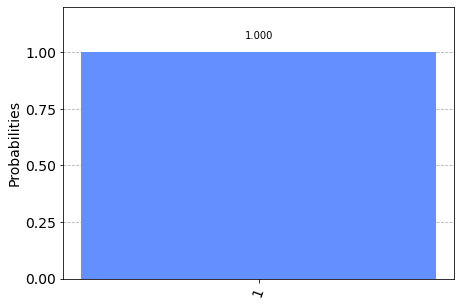

In [2]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, execute
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

qr = QuantumRegister(2, "q")
cr = ClassicalRegister(1, "c")
qc = QuantumCircuit(qr, cr)

# Чтобы увидеть эффект, подготовим состояние |+> в управляющем кубите. 
# Если бы не работал, мы бы увидели - |0> -> |+> -> |0>,
# Но мы увидим |0> -> |+> -> (!)|-> -> |1>
qc.h(qr[0])
# или можно так:
# qc.initialize([0.5 ** 0.5, 0.5 ** 0.5], qr[0])

qc.barrier()

# подгтовим состояние |-> - собственнре для X in qr[1]
qc.x(qr[1])
qc.h(qr[1])
# или можно так:
# qc.initialize([0.5 ** 0.5, -0.5 ** 0.5], qr[1])

qc.barrier()

# Controlled NOT
qc.cx(0, 1)
qc.barrier()

# готовим однозначно измеримое состояние
qc.h(qr[0])

qc.measure(qr[0], cr[0])
print(qc.draw())

job = execute(qc, Aer.get_backend('qasm_simulator'), shots=1)
counts = job.result().get_counts(qc)
plot_histogram(counts)